
## What is paper replicating?

Tujuan utama dari **paper replicating** adalah untuk mereplikasi kemajuan paper machine learning dengan kode. Jadi, kita dapat memahami makalah dengan lebih baik dan juga dapat menggunakan kode untuk penelitian kita sendiri.

![paper replicating](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-what-is-paper-replicating-images-math-text-to-code.png)

## What is machine learning research paper?

Machine learning paper adalah makalah ilmiah yang merinci temuan kelompok penelitian tentang topik machine learning tertentu.

Bagian utama dari paper machine learning adalah:
- **Abstrak**: ringkasan dari temuan utama paper.
- **Pendahuluan**: masalah utama paper dan rincian metode sebelumnya yang digunakan untuk menyelesaikannya.
- **Metode**: metode yang digunakan penulis paper untuk memecahkan masalah. Misalnya, model, sumber data, pengaturan pelatihan.
- **Hasil**: hasil dari metode yang digunakan. Misalnya, kinerja model pada set data tertentu dibandingkan dengan pekerjaan sebelumnya. (experiment tracking)
- **Kesimpulan**: ringkasan temuan, keterbatasan, dan kemungkinan pekerjaan di masa depan.
- **Rujukan**: daftar paper yang digunakan penulis paper untuk menginformasikan pekerjaan mereka.
- **Lampiran**: informasi tambahan mengenai metode yang digunakan dalam paper. Misalnya, bukti matematis, hasil eksperimen tambahan.

## Why replicate a machine learning research paper?

Machine learning paper sering kali merupakan presentasi metode baru untuk memecahkan masalah. Penulis makalah sering kali menyertakan deskripsi metode, hasil, dan kode mereka.

Selain itu, meniru karya orang lain adalah cara yang bagus untuk melatih kemampuan kita.

![step how to improve](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-george-hotz-quote.png)

## Where to find machine learning research papers?

Ada beberapa tempat untuk menemukan dan membaca paper machine learning. Beberapa yang paling populer adalah:
- [Arxiv](https://arxiv.org/) - tempat penyimpanan makalah ilmiah gratis, banyak di antaranya terkait dengan ML.
- [Papers with code](https://paperswithcode.com/) - tempat penyimpanan makalah ML dengan kode.
- [AK Twitter](https://twitter.com/ak92501) - seorang peneliti ML yang men-tweet tentang makalah ML yang menarik.
- [lucidrains GitHub](https://github.com/lucidrains/vit-pytorch) - repositori GitHub dari makalah ML dengan kode.
- [Reddit machine learning](https://www.reddit.com/r/MachineLearning/) - subreddit yang didedikasikan untuk ML.

## 0. Setup

In [4]:
!pip install torchinfo

In [5]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [7]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [8]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and Dataloaders

ViT use **224x224** image size and **4096** batch size.

![vit image and batch size](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-image-size-and-batch-size.png)

### 2.1 Prepare transforms for images

In [9]:
# Image size from ViT paper
IMG_SHAPE = 224

# create manual transform
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SHAPE, IMG_SHAPE)),
    transforms.ToTensor(),
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

### 2.2 Turn images into DataLoader

In [10]:
# set the batch size
BATCH_SIZE = 8

# create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78829eda83a0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize single image

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

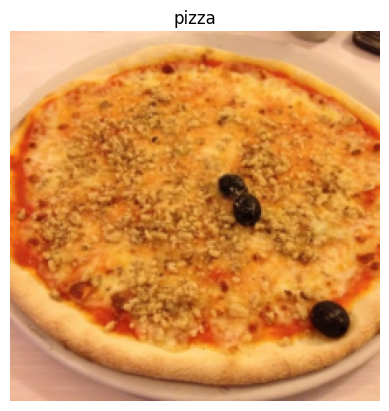

In [12]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating the ViT paper: an overview

### 3.1 Inputs and outputs, layers and blocks

ViT merupakan **arsitektur** deep learning neural network. Dan di dalamnya terdapat beberapa **layer**, layer yang ditumpuk disebut dengan **block**. Dengan menumpuk banyak **block** menjadi satu maka akan didapatkan keseluruhan **arsitektur**.

Sebuah **layer** menerima input image tensor dan melakukan operasi dari fungsi di dalamnya dan mengembalikan output.

Dengan demikian:

- **Layer** - menerima input, menjalankan fungsi, dan mengembalikan output.
- **Block** - kumpulan dari layer, menerima input, menjalankan beberapa fungsi, dan mengembalikan output.
- **Arsitektur (model)** - kumpulan dari blok, menerima input, menjalankan beberapa fungsi, dan mengembalikan output.

Ideologi diatas merupakan dasar dari replikasi paper ViT ini. (berbasis block building, seperti Lego)

![vit block building](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png)

### 3.2 Getting specific: What's ViT made of?

#### 3.2.1 Exploring the ViT architecture

![vit architecture](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png)

Berikut adalah penjelsannya:

- **Patch + Position Embedding (inputs)** - mengubah gambar input menjadi `sequence of patches` dan menambahkan informasi posisi ke setiap patch.
- **Linear projection of flattened patches (Embedded Patches)** - mengubah setiap patch menjadi `embedding vector`. Benefit penggunaan embedding dibanding dengan image value adalah embedding merupakan `learned representation` yang dapat meningkat dengan training.
- **Norm (Layer Normalization)** - teknik untuk regularisasi (mengurangi overfitting) neural network dengan mengurangi nilai input ke layer.
- **Multi-Head Attention (MSA)** - [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) digunakan untuk memproses vector untuk memahami hubungan antar sequence of image input. Implementasinya nanti akan menggunakan `torch.nn.MultiheadAttention`.
- **Multilayer Perceptron (MLP)** - kumpulan dari feedfoward layers.
- **Transformer Encoder** - kumpulan dari MSA dan MLP. (block)
- **MLP Head** - output layer dari arsitektur, mengubah fitur yang dipelajari dari input menjadi output.

#### 3.2.2 Exploring the Four Equations

![vit four equations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

Berikut adalah penjelasannya:
| Equation number | Description from ViT paper section 3.1                                                  |
|-----------------|-------------------------------------------------------------------------------------------|
| 1               | The Transformer uses constant latent vector size **D** through all of its layers, so we flatten the patches and map to **D** dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**. **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**. |
| 2               | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self-attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layer norm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3               | Same as equation 2.                                                                         |
| 4               | Similar to BERT's [class] token, we **prepend a learnable embedding to the sequence of embedded patches (z₀₀ = x_class)**, whose state at the output of the Transformer encoder (**z₀L**) serves as the image representation **y** (Eq. 4).                      |


**Arsitektur ViT dengan penjelasan** rumus diatas:
![vit architecture with equations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png)

Dalam semua persamaan (kecuali persamaan 4), $z$ adalah hasil keluaran mentah dari lapisan tertentu:

- $z_0$ adalah "z nol" (ini adalah hasil keluaran dari lapisan awal pembentukan patch).
- $z'_ℓ$ adalah "z dari lapisan tertentu prime" (atau nilai perantaraan dari $z$).
- $z_ℓ$ adalah "z dari lapisan tertentu".
- $y$ adalah hasil keluaran keseluruhan dari arsitektur.


#### 3.2.3 Equation 1 overview

\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}

Persamaan diatas berhubungan dengan class token, patch embedding, dan position embedding (**E** = Embedding) dari input image.

Dalam bentuk vector, embedding diatas akan terlihat seperti:

``` py
x_input = [class_token, image_patch_1, image_patch_2, ...] + [class_token_position, image_patch_1_position, image_patch_2_position, ...]
```

Tiap element pada vector diatas adalah learnable (maka `requires_grad=True`).

#### 3.2.4 Equation 2 overview

\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}

Setiap layer dari **1** hingga **L** (total number of layer), ada layer Multi-Head Attention (MSA) yang membungkus LayerNorm layer (LN). Di akhir terdapat penambahan dari output layer sebelumnya (residual connection).

Pseudocode dari persamaan diatas:
``` py
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

#### 3.2.5 Equation 3 overview

\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}

Setiap layer dari **1** hingga **L** (total number of layer), ada layer Multilayer Perceptron layer (MLP) yang membungkus LayerNorm layer (LN). Di akhir terdapat penambahan dari output layer sebelumnya (residual connection).

Pseudocode dari persamaan diatas:
``` py
x_output_MLP_block = MLP_layer(LN_layer(x_input)) + x_input
```

#### 3.2.6 Equation 4 overview

\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}

Last layer **L**, output **y** adalah index tokens 0 dari **z** yang dibungkus oleh LayerNorm layer (LN).

Dalam konteks ini, 0 index dari `x_output_MLP_block`:
``` py
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

#### 3.2.7 Exploring Table 1

| Model       | Layers | Hidden size (D) | MLP size | Heads | Params (Millions) |
|-------------|--------|------------------|----------|-------|-------------------|
| ViT-Base    | 12     | 768              | 3072     | 12    | 86                |
| ViT-Large   | 24     | 1024             | 4096     | 16    | 307               |
| ViT-Huge    | 32     | 1280             | 5120     | 16    | 632               |


Sesuai tabel diatas, ViT memiliki Hyperparameter sebagai berikut:
- **Layers**: jumlah Transformer Encoder block yang digunakan (MSA block dan MLP block)
- **Hidden size D** - embedding dimension pada setiap layer, ini juga menjadi ukuran dari vector dari image yang diubah ketika patch embedding.
- **MLP size** - jumlah hidden unit pada MLP layer.
- **Heads** - jumlah head pada MSA layer.
- **Params** - total parameter yang digunakan untuk model.

### 3.3 Replicating papers workflow

1. Read the whole paper end-to-end once (to get an idea of the main concepts).
2. Go back through each section and see how they line up with each other and start thinking about how they might be turned into code (just like above).
3. Repeat step 2 until I've got a fairly good outline.
4. Use [mathpix.com](mathpix.com) (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
5. Replicate the simplest version of the model possible.
6. If I get stuck, look up other examples.

## 4. Equation 1: Split data into patches and creating the class, position and patch embeddings

**Embeddings adalah learnable representation**. Dengan kata lain, embedding adalah representasi dari data yang dipelajari oleh model.

![embedding](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png)

Berikut adalah penjelasan dari gambar diatas:
- **D** adalah size of the **patch embeddings**, ukurannya dapat dilihat pada **Table 1**.
- Image berbentuk 2D dengan ukuran **H x W x C** (height, width, channel).
- Image dapat diubah menjadi sequence of flattened 2D patches dengan ukuran **N × (P^2 ⋅ C)**
  - **(P, P)** adalah ukuran dari setiap patch (**patch size**).
  - **N = HW / P^2** adalah jumlah patch yang dihasilkan dari image, dimana juga merupakan input sequence length untuk model.

### 4.1 Calculating patch embedding input and output shapes by hand

>Notes: biar lebih paham dan terbayang ilustrasinya

In [13]:
# Sample values
height = 224        # H
width = 224         # W
color_channels = 3  # C
patch_size = 16     # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


Dengan demikian:
- **Input**: image tensor dengan ukuran **H x W x C**
- **Output**: sequence of flattened 2D patches dengan ukuran **N × (P^2 ⋅ C)**

In [14]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 4.2 Turning a single image into patches

>Notes: masih sebuah ilustrasi, bukan penerapan real pada modelnya nanti

In [15]:
# # View single image
# plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
# plt.title(class_names[label])
# plt.axis(False);

In [16]:
# # Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
# image_permuted = image.permute(1, 2, 0)

# # Index to plot the top row of patched pixels
# patch_size = 16
# plt.figure(figsize=(patch_size, patch_size))
# plt.imshow(image_permuted[:patch_size, :, :]);

In [17]:
# # Setup hyperparameters and make sure img_size and patch_size are compatible
# img_size = 224
# patch_size = 16
# num_patches = img_size/patch_size
# assert img_size % patch_size == 0, "Image size must be divisible by patch size"
# print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# # Create a series of subplots
# fig, axs = plt.subplots(nrows=1,
#                         ncols=img_size // patch_size, # one column for each patch
#                         figsize=(num_patches, num_patches),
#                         sharex=True,
#                         sharey=True)

# # Iterate through number of patches in the top row
# for i, patch in enumerate(range(0, img_size, patch_size)):
#     axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
#     axs[i].set_xlabel(i+1) # set the label
#     axs[i].set_xticks([])
#     axs[i].set_yticks([])

In [18]:
# # Setup hyperparameters and make sure img_size and patch_size are compatible
# img_size = 224
# patch_size = 16
# num_patches = img_size/patch_size
# assert img_size % patch_size == 0, "Image size must be divisible by patch size"
# print(f"Number of patches per row: {num_patches}\
#         \nNumber of patches per column: {num_patches}\
#         \nTotal patches: {num_patches*num_patches}\
#         \nPatch size: {patch_size} pixels x {patch_size} pixels")

# # Create a series of subplots
# fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
#                         ncols=img_size // patch_size,
#                         figsize=(num_patches, num_patches),
#                         sharex=True,
#                         sharey=True)

# # Loop through height and width of image
# for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
#     for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

#         # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
#         axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
#                                         patch_width:patch_width+patch_size, # iterate through width
#                                         :]) # get all color channels

#         # Set up label information, remove the ticks for clarity and set labels to outside
#         axs[i, j].set_ylabel(i+1,
#                              rotation="horizontal",
#                              horizontalalignment="right",
#                              verticalalignment="center")
#         axs[i, j].set_xlabel(j+1)
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])
#         axs[i, j].label_outer()

# # Set a super title
# fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
# plt.show()

>Program diatas adalah ilustrasi dari cara mengubah image menjadi sequence of patches. Untuk implementasi di model nanti kita dapat memanfaatkan **layer konvolusi pada PyTorch** yang mengoutputkan vector berukuran seperti sequence of patches.

### 4.3 Creating image patches with `torch.nn.Conv2d()`

Menurut penulis, alternatif dari raw image patches adalah dengan menggunakan **feature maps dari CNN**. Dimana input sequence ViT nanti didapatkan dari flattening spatial dimension dari feature maps dan memproyeksikan ke Transformer dimension.

Feature map adalah weights/activation yang dihasilkan oleh layer konvolusi setelah melakukan operasi konvolusi pada input image.

Ingat:
- **Input**: image tensor dengan ukuran **H x W x C**
- **Output**: sequence of flattened 2D patches dengan ukuran **N × (P^2 ⋅ C)**

Jika image size adalah 224 dan patch size adalah 16, maka:
- **Input (2D image)**: (224, 224, 3) -> (height, width, color channels)
- **Output (flattened 2D patches)**: (196, 768) -> (number of patches, embedding dimension)

In [19]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

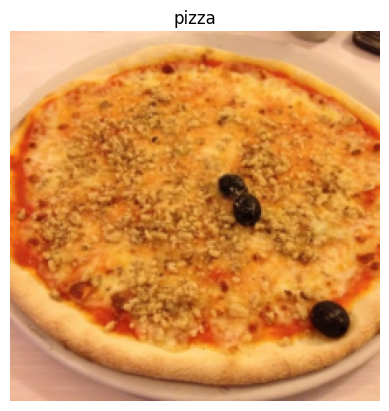

In [20]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [21]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)
print("[batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14])
[batch_size, embedding_dim, feature_map_height, feature_map_width]


Dengan demikian jika kita memasukkan image ke convolutional layer maka akan menjadi series of 768 (merupakan embedding size atau **D**) feature/activation maps.

Maka output shape dapat dibaca sebagai:
``` py
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [426, 401, 704, 462, 39]


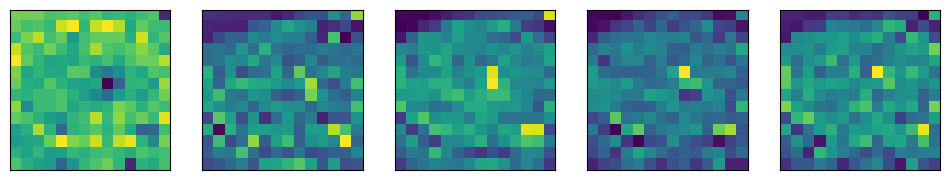

In [22]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

Kunci penting dalam mengubah image menjadi sequence of patches baik dengan cara membuat patches secara manual (yang kemudian masuk ke linear layer) atau dengan menggunakan convolutional layer adalah **learnable embedding**.

Karena hal tersebut setiap iterasi proses training akan berubah hingga ke nilai yang optimal.

In [23]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.1998, 0.2010, 0.2010, 0.1739, 0.1679, 0.1696, 0.1449, 0.1268,
           0.1428, 0.1626, 0.1607, 0.1974, 0.2503, 0.0395],
          [0.1981, 0.1814, 0.1587, 0.1559, 0.2146, 0.1837, 0.1167, 0.0920,
           0.1667, 0.1850, 0.1367, 0.1674, 0.1747, 0.1888],
          [0.1462, 0.1745, 0.0914, 0.1021, 0.1954, 0.0978, 0.1434, 0.1520,
           0.1159, 0.1839, 0.1070, 0.1144, 0.1339, 0.1734],
          [0.0975, 0.1508, 0.1100, 0.1475, 0.1090, 0.1065, 0.1193, 0.1382,
           0.1519, 0.1765, 0.2030, 0.1263, 0.1503, 0.1140],
          [0.1159, 0.1853, 0.0953, 0.1713, 0.1656, 0.1606, 0.1141, 0.1571,
           0.0926, 0.1043, 0.1045, 0.1222, 0.1352, 0.1326],
          [0.0856, 0.1601, 0.1129, 0.1715, 0.1395, 0.0780, 0.1392, 0.0613,
           0.0735, 0.2226, 0.1630, 0.1400, 0.1328, 0.1554],
          [0.0561, 0.1141, 0.1033, 0.1102, 0.1544, 0.1468, 0.1170, 0.1285,
           0.0131, 0.2020, 0.1932, 0.1999, 0.1371, 0.1415],
          [0.1383, 0.1575, 0.1201, 0.1458, 0.0454, 0.12

Dapat dibuktikan pada kode diatas, bahwa feature map memiliki atribut `requires_grad=True`.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Output yang diinginkan adalah (196, 768) -> (number of patches, embedding dimension) -> **N × (P^2 ⋅ C)**

Untuk melakukan hal tersebut kita dapat menggunakan `torch.nn.Flatten()`.

In [24]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [25]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


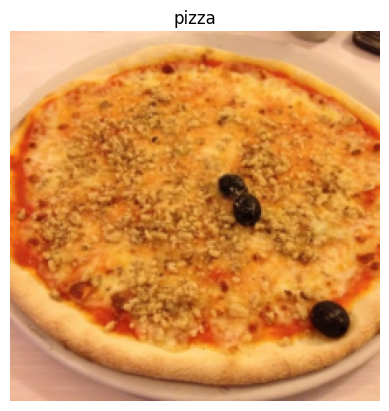

In [26]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Tahap diatas belum selesai, karena format datanya belum sesuai:
- **Desired output (flattened 2D patches)**: (196, 768) -> (number of patches, embedding dimension) -> **N × (P^2 ⋅ C)**
- **Current output**: (1, 768, 196)

In [27]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


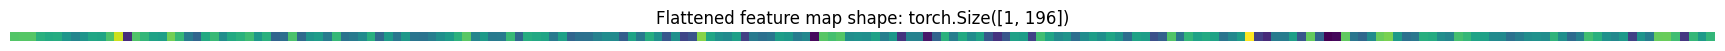

In [28]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [29]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.1998, 0.2010, 0.2010, 0.1739, 0.1679, 0.1696, 0.1449, 0.1268, 0.1428,
          0.1626, 0.1607, 0.1974, 0.2503, 0.0395, 0.1981, 0.1814, 0.1587, 0.1559,
          0.2146, 0.1837, 0.1167, 0.0920, 0.1667, 0.1850, 0.1367, 0.1674, 0.1747,
          0.1888, 0.1462, 0.1745, 0.0914, 0.1021, 0.1954, 0.0978, 0.1434, 0.1520,
          0.1159, 0.1839, 0.1070, 0.1144, 0.1339, 0.1734, 0.0975, 0.1508, 0.1100,
          0.1475, 0.1090, 0.1065, 0.1193, 0.1382, 0.1519, 0.1765, 0.2030, 0.1263,
          0.1503, 0.1140, 0.1159, 0.1853, 0.0953, 0.1713, 0.1656, 0.1606, 0.1141,
          0.1571, 0.0926, 0.1043, 0.1045, 0.1222, 0.1352, 0.1326, 0.0856, 0.1601,
          0.1129, 0.1715, 0.1395, 0.0780, 0.1392, 0.0613, 0.0735, 0.2226, 0.1630,
          0.1400, 0.1328, 0.1554, 0.0561, 0.1141, 0.1033, 0.1102, 0.1544, 0.1468,
          0.1170, 0.1285, 0.0131, 0.2020, 0.1932, 0.1999, 0.1371, 0.1415, 0.1383,
          0.1575, 0.1201, 0.1458, 0.0454, 0.1236, 0.1228, 0.0235, 0.0903, 0.1759,
          0.1195

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

In [30]:
flatten

Flatten(start_dim=2, end_dim=3)

In [31]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    def __init__(
        self,
        in_channels:int=3,
        patch_size:int=16,
        embedding_dim:int=768,
    ):
        super().__init__()

        # Patcher layer: turn an image into patches
        self.patcher  = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        # Flatten layer: flatten patch feature maps into a single dimension
        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3,
        )

    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # perform forward pass
        out = self.patcher (x)
        out = self.flatten(out)
        out = out.permute(0, 2, 1)
        return out

In [32]:
# test PatchEmbedding layer
set_seeds()

patch_layer = PatchEmbedding()

image_in = torch.unsqueeze(image, dim=0)
patch_embedded_image = patch_layer(image_in)
image_in.shape, patch_embedded_image.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 196, 768]))

>**Done patch embedding layer**

![patch embedding layer](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-replicating-the-patch-embedding-layer.png)

In [33]:
# Patch embedding layer summary
summary(
    PatchEmbedding(),
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 4.6 Creating the class token embedding

![class token embedding](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-class-token.png)

Class token embedding atau $\mathbf{z}_{0}^{0}=\mathbf{x}_{\text{class}}$ adalah representasi vector dari seluruh gambar, dan merupakan peran penting dalam model untuk memproses dan memahami gambar secara keseluruhan.

Class token ini perlu dipelajari oleh model, maka dari itu kita perlu membuatnya sebagai **learnable embedding**.

In [34]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.9239,  0.2020, -0.2110,  ...,  0.6356, -0.4239,  0.3361],
         [-0.9232,  0.1995, -0.2139,  ...,  0.6398, -0.4392,  0.3357],
         [-0.9277,  0.1942, -0.2119,  ...,  0.6466, -0.4423,  0.3473],
         ...,
         [-0.7726,  0.2036, -0.0730,  ...,  0.4033, -0.3767,  0.1504],
         [-0.6403,  0.1017, -0.2165,  ...,  0.4974, -0.3035,  0.2624],
         [-0.8515,  0.1774, -0.2060,  ...,  0.5579, -0.3775,  0.3122]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Untuk menambah learnable embedding ke sequence of embedded patches, kita perlu membuat **learnable embedding** dengan ukuran **D** (embedding dimension) dan menambahkannya ke `number_of_patches` dimension.

Pseudocode:
``` py
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

Untuk membuat learnable_embedding kita dapat membuat sebuah `torch.ones()` dengan ukuran [batch_size, 1, embedding_dim] dan `requires_grad=True`.

>Notes: pada contoh ini memang menggunakan `torch.ones()` karena kita ingin membuat learnable embedding yang berisi 1. Namun pada implementasi nanti kita dapat menggunakan `torch.randn()` untuk membuat learnable embedding yang berisi angka random.

In [35]:
# get batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True
)

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [36]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image),
    dim = 1
)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape:")
print(f"{patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9239,  0.2020, -0.2110,  ...,  0.6356, -0.4239,  0.3361],
         [-0.9232,  0.1995, -0.2139,  ...,  0.6398, -0.4392,  0.3357],
         ...,
         [-0.7726,  0.2036, -0.0730,  ...,  0.4033, -0.3767,  0.1504],
         [-0.6403,  0.1017, -0.2165,  ...,  0.4974, -0.3035,  0.2624],
         [-0.8515,  0.1774, -0.2060,  ...,  0.5579, -0.3775,  0.3122]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape:
torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


![class token embedding](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-prepending-the-learnable-class-token.png)

### 4.7 Creating the position embedding

Position embedding or $\mathbf{E}_{\text{pos}}$ adalah representasi vector dari posisi setiap patch pada gambar. Tujuannya adalah untuk memberitahu model posisi setiap patch pada gambar.

![position embedding](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png)



In [37]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9239,  0.2020, -0.2110,  ...,  0.6356, -0.4239,  0.3361],
          [-0.9232,  0.1995, -0.2139,  ...,  0.6398, -0.4392,  0.3357],
          ...,
          [-0.7726,  0.2036, -0.0730,  ...,  0.4033, -0.3767,  0.1504],
          [-0.6403,  0.1017, -0.2165,  ...,  0.4974, -0.3035,  0.2624],
          [-0.8515,  0.1774, -0.2060,  ...,  0.5579, -0.3775,  0.3122]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Pada persamaan 1 dijelaskan bahwa position embeddings ($\mathbf{E}_{\text{pos}}$) harus memiliki shape (N+1, D)

\begin{aligned}
\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}

Dimana:
- **N = HW / P^2** adalah jumlah patch yang dihasilkan dari image, dimana juga merupakan input sequence length untuk model.
- **D** adalah size of the **patch embeddings**, ukurannya dapat dilihat pada **Table 1**.

In [38]:
# calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# get D (embedding dimension)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# create learnable 1d position embedding
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches+1, embedding_dimension),
    requires_grad=True # must be True for learnable
)

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Sesuai persamaan 1 diatas, maka kita perlu menambahkan position embedding ke sequence of embedded patches.

In [39]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0761, 1.2020, 0.7890,  ..., 1.6356, 0.5761, 1.3361],
         [0.0768, 1.1995, 0.7861,  ..., 1.6398, 0.5608, 1.3357],
         ...,
         [0.2274, 1.2036, 0.9270,  ..., 1.4033, 0.6233, 1.1504],
         [0.3597, 1.1017, 0.7835,  ..., 1.4974, 0.6965, 1.2624],
         [0.1485, 1.1774, 0.7940,  ..., 1.5579, 0.6225, 1.3122]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


>**Note**: We could put both the class token embedding and position embedding into their own layer if we wanted to. But we'll see later on in section 8 how they can be incorporated into the overall ViT architecture's `forward()` method.

![position embedding](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-patch-embeddings-with-learnable-class-token-and-position-embeddings.png)

### 4.8 Putting it all together: from image to embedding

In [40]:
image.shape

torch.Size([3, 224, 224])

In [41]:
set_seeds()

# set patch size
patch_size = 16

# H and W
_, height, width = image.shape
number_of_patches = int((height*width)/patch_size**2)
embedding_dimension = patch_size**2 * 3

# add batch dimension
image_input = image.unsqueeze(dim=0)

# patch embedding layer
patch_embedder = PatchEmbedding(
    in_channels=3,
    patch_size=patch_size,
    embedding_dim=embedding_dimension
)

# feed patch embedding layer
patch_embedding = patch_embedder(image_input)

# create class token embedding
batch_size = patch_embedding.shape[0]

class_token = torch.ones(
    size=(batch_size, 1, embedding_dimension),
    requires_grad=True
)

# concat class token embedding and patch embedding
patch_embedding_class_token = torch.cat(
    (class_token, patch_embedding),
    dim=1
)

# create position embedding
position_embedding = nn.Parameter(
    torch.ones(
        size=(batch_size, number_of_patches+1, embedding_dimension),
    ),
    requires_grad=True
)

# add position embedding to patch embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding

# final result
print(f"Image tensor shape: {image.shape}")
print(f"Input image with batch dimension shape: {image_input.shape}")
print(f"Patching embedding shape: {patch_embedding.shape}")
print(f"Class token embedding shape: {class_token.shape}")
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


Itulah tahapan awal dari ViT, membuat patch and position embedding dari image.

![image to embedding](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-putting-it-all-together.png)

## 5. Equation 2: Multi-Head Self-Attention (MSA)

\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}

Dari persamaan diatas didapatkan bahwa layer MSA membungkus layer LN dengan residual connection (penambahan output layer sebelumnya).

![multi-head self-attention](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png)

Dalam penerapan kali ini kita akan menggunakan:
- **Multi-Head Self Attention (MSA)** - `torch.nn.MultiheadAttention()`
- **Layer Normalization (LN)** - `torch.nn.LayerNorm()`
- **Residual connection** - menambah input ke output

### 5.1 The LayerNorm (LN) layer

[Layer Normalization](https://paperswithcode.com/method/layer-normalization) akan menormalisasi input pada dimensi terakhir.

Pada `torch.nn.LayerNorm()` kita dapat menentukan `normalized_shape` yang merupakan ukuran dari dimensi terakhir (dalam kasus ini adalah **D** / `768`).

### 5.2 THe Multi-Head Self-Attention (MSA) layer

**Multi-Head Self-Attention** adalah teknik yang digunakan dalam model Transformer untuk memproses teks dengan memungkinkan model untuk memahami hubungan antar kata dalam beberapa cara yang berbeda secara simultan (dalam konteks kita adalah patches gambar).

Input pada kita adalah sequence of image patches dan prosesnya nanti akan menghitung hubungan antar patches dan akan mencari hubungan yang paling penting.

Referensi agar lebih paham [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) dan [Illustrated Attention](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/).

![multi-head self-attention](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png)

Pada gambar diatas, kita dapat melihat bahwa input dari MSA adalah **Q** (query), **K** (key), dan **V** (value). Ketiga nilai tersebut adalah fundamental dari mekanisme self-attention. Berikut adalah penjelasan dari ketiga nilai tersebut:
- **Query (Q)** - representasi `pertanyaan` untuk mencari hubungan antar patches.
- **Key (K)** - representasi `kunci` yang digunakan untuk mencocokan dengan Query. Key juga digunakan untuk menentukan sejauh mana token saat ini relevan dengan token lainnya.
- **Value (V)** - mewakili `nilai` yang akan diambil sebagai hasil dari proses attention. Nilai ini akan diambil untuk menggambarkan tingkat kontribusi dari setiap token terhadap token saat ini berdasarkan hasil dari perbandingan antara Q dan K.

Ketiga nilai tersebut merupakan output dari layer LN sebelumnya yang masing-masing memiliki bentuk yang sama dengan input (batch_size, num_tokens, dimensi_representasi) atau lengkapnya ini:
- 1 adalah ukuran batch.
- 196 adalah jumlah patch yang ada dalam gambar.
- 768 adalah dimensi dari setiap representasi vektor patch.

Jadi nilai QKV akan berjumlah 196 dengan masing-masing memiliki dimensi 768.

Pada implementasi kali ini kita akan menggunakan `torch.nn.MultiheadAttention()`. Dimana memiliki parameter sebagai berikut:
- **embed_dim** - total dimension dari input dan output (Hidden size **D**).
- **num_heads** - jumlah head yang digunakan untuk attention.
- **dropout** - dropout probability.
- **batch_first** - jika True maka input dan output akan memiliki shape (batch_size, seq_len, embed_dim).

### 5.3 Replicating Equation 2 with PyTorch layers


In [42]:
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(
        self,
        embedding_dim:int=768, # hidden size D
        num_heads:int=12, # number of head for self-attention
        attn_dropout:float=0
    ):
        super().__init__()

        # Norm layer (LN)
        self.layer_norm  = nn.LayerNorm(
            normalized_shape=embedding_dim
            )

        self.multihead_attn  = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True # lihat format input, apakah batch-nya terlebih dahulu
        )

    def forward(self, x):
        x = self.layer_norm (x)
        attn_output, _ = self.multihead_attn(
            query=x, # query embedding
            key=x, # key embedding
            value=x, # value embedding
            need_weights=False # do we need the weights or just the layer outputs? (bobot weight dari attention untuk output return)
        )
        return attn_output

>**Note**: Unlike Figure 1, our `MultiheadSelfAttentionBlock` doesn't include a skip or residual connection ($+\mathbf{z}_{\ell-1}$ in equation 2), we'll include this when we create the entire Transformer Encoder later on in section 7.1.

In [43]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(
    embedding_dim=768, # from Table 1
    num_heads=12  # from Table 1
)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


Bentuk input dan output dari hasil block diatas sama karena dalam operasi self-attention, setiap token dalam gambar akan berinteraksi dengan token lainnya, termasuk dirinya sendiri. Walaupun bentuknya sama, namun nilainya akan berbeda karena mencerminkan tingkat kontribusi atau relevansi setiap token terhadap token lainnya berdasarkan hasil perhitungan attention.

![multi-head self-attention block](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-in-code.png)

Proses lengkap yang terjadi pada block `MultiheadSelfAttentionBlock` adalah:

- **Input Layer MSA (Multihead Self-Attention)**: Input layer MSA adalah nilai QKV (Query, Key, Value) yang berasal dari satu sumber, seperti lapisan Normalisasi (LayerNorm). Setiap nilai Q, K, dan V memiliki bentuk (batch_size, num_patches, dimensi_patch). Ini adalah representasi dari setiap patch dalam gambar setelah melewati pemrosesan sebelumnya.

- **Perhitungan Attention**: Di dalam layer MSA, dilakukan perhitungan attention menggunakan nilai Q, K, dan V. Ini melibatkan perbandingan (matching) antara setiap pasangan token dalam gambar, dan hasil attention menggambarkan sejauh mana setiap token berkontribusi terhadap token lainnya.

- **Output Layer MSA**: Hasil perhitungan attention, yang merupakan representasi baru untuk setiap token, akan memiliki bentuk yang sama dengan input, yaitu (batch_size, num_patches, dimensi_patch). Namun, nilainya akan berbeda karena mencerminkan tingkat kontribusi atau relevansi setiap token terhadap token lainnya berdasarkan hasil perhitungan attention.

## 6. Equation 3: Multi-Layer Perceptron (MLP)

\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}

![multi-layer perceptron](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-3-annotated.png)

### 6.1 The MLP layer(s)

Struktur dari MLP block pada ViT adalah sebagai berikut:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

Dimana:
- **Layer norm** - `torch.nn.LayerNorm()`
- **Linear layer** - `torch.nn.Linear()`
- **Non-linear layer** - `torch.nn.GELU()`

### 6.2 Replicating Equation 3 with PyTorch layers

In [44]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""

    def __init__(
        self,
        embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
        mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
        dropout:float=0.0, # Dropout from Table 3 for ViT-Base
    ):
        super().__init__()

        # normalization layer
        self.layer_norm  = nn.LayerNorm(
            normalized_shape=embedding_dim
        )

        # MLP layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(
                in_features=embedding_dim,
                out_features=mlp_size
            ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,
                out_features=embedding_dim
            ),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

>Note: Unlike Figure 1, our MLPBlock() doesn't include a skip or residual connection ("$+\mathbf{z}_{\ell}^{\prime}$" in equation 3), we'll include this when we create the entire Transformer encoder later on.

In [45]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


Bentuk input dan output pada MLP block sama, yaitu (batch_size, num_patches, dimensi_patch). Block MLP bertindak sebagai lapisan pemrosesan feedforward yang membantu dalam menggali lebih dalam informasi dari representasi hasil attention sebelumnya.

Output dari block MLP adalah representasi yang diperbarui dari setiap token dalam gambar. Ini adalah representasi yang lebih dalam dan kaya yang dapat digunakan dalam lapisan-lapisan selanjutnya dari model untuk tugas klasifikasi, deteksi objek, atau tugas lainnya yang terkait dengan pemrosesan gambar.

![multi-layer perceptron block](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-3-mapped-to-code.png)

## 7. Create the Transformer Encoder

Menggabungkan `MultiheadSelfAttentionBlock` dan `MLPBlock` menjadi `TransformerEncoderBlock`.

Pada deep learning, [**encoder**](https://paperswithcode.com/method/autoencoder) adalah bagian dari model yang bertugas untuk mengubah input menjadi representasi yang lebih dalam dan kaya. Representasi ini kemudian akan digunakan oleh **decoder** untuk memprediksi output.

Pada kasus ini, Transformer Encoder akan mengubah sequence of image patches menjadi representasi yang lebih dalam dan kaya. Dan pada block ini terdapat [**residual connection**](https://paperswithcode.com/method/residual-connection) yang menghubungkan input dari `MSA block` dan output dari `MSA block`

Pseudo code dari `TransformerEncoderBlock` adalah sebagai berikut:
`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`

Tujuan dari residual connection adalah untuk mencegah weight values dan gradient updates menjadi terlalu kecil atau menghilang (vanishing gradient). Hal ini dapat terjadi ketika kita memiliki banyak layer yang saling berhubungan.

### 7.1 Creating a Transformer Encoder by combining our custom made layers

In [46]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""

    def __init__(
        self,
        embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
        num_heads:int=12, # Heads from Table 1 for ViT-Base
        mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
        mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
        attn_dropout:float=0 # Amount of dropout for attention layers
        ):
        super().__init__()

        # create a MSA block
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout
        )

        # create a MLP block
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )

    def forward(self, x):
        # residual connection for msa block
        x = self.msa_block(x) + x
        # residual connection for mlp block
        x = self.mlp_block(x) + x
        return x

![transformer encoder](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-highlighted.png)

![mapping transformer encoder to code](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-mapped-to-code.png)

In [47]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
# summary(model=transformer_encoder_block,
#         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers (built-in)

Jika kita tidak ingin ribet, kita dapat menggunakan built-in layer dari PyTorch yaitu `torch.nn.TransformerEncoderLayer()` dan `torch.nn.TransformerEncoder()`.

In [48]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768, # Hidden size D from Table 1 for ViT-Base
    nhead=12, # Heads from Table 1 for ViT-Base
    dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
    dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
    activation="gelu", # GELU non-linear activation
    batch_first=True, # Do our batches come first?
    norm_first=True # Normalize first or after MSA/MLP layers?
    )

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

## 8. Putting it all together to create ViT

In [49]:
from torch import nn

In [50]:
class ViT(nn.Module):

    def __init__(
        self,
        img_size:int=224,
        in_channels:int=3,
        patch_size:int=16,
        num_transformer_layers:int=12,
        embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
        mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
        num_heads:int=12, # Heads from Table 1 for ViT-Base
        attn_dropout:float=0, # Amount of dropout for attention layers
        mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
        embedding_dropout:float=0.1,
        num_classes:int=3, # default for ImageNet1k is 1000 but we only use 3 later

    ):
        super().__init__()
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_of_patches = int((img_size**2)/patch_size**2)

        # Parameter: class token
        self.class_embedding = nn.Parameter(
            torch.ones(1, 1, embedding_dim),
            requires_grad=True
        )

        # Parameter: position embedding
        self.position_embedding = nn.Parameter(
            torch.ones(1, self.num_of_patches+1, embedding_dim),
            requires_grad=True
        )

        # Layer: embedding dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Layer: patch embedding
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim,
        )

        # Layer: transformer encoder block
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=mlp_dropout,
                attn_dropout=attn_dropout,
            ) for _ in range(num_transformer_layers)]
        )

        # Layer: MLP head (classifier)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(
                in_features=embedding_dim,out_features=num_classes
                )
        )

    def forward(self, x):
        # get batch size
        batch_size = x.shape[0]

        # equation 1
        # create patch embedding
        x = self.patch_embedding(x)

        # create class embedding
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # concat class embedding to patch embedding
        x = torch.cat((class_token, x), dim=1)

        # add position embedding to patch embedding
        x = self.position_embedding + x

        # pass patch and position embedding to dropout layer
        x = self.embedding_dropout(x)

        # equation 2 & 3
        # pass patch and position embedding to transformer encoder
        x = self.transformer_encoder(x)

        # equation 4
        # pass index 0 output of transformer encoder layer to classifier head
        x = self.mlp_head(x[:, 0])

        return x

Pada `class ViT` di atas terdapat method `expand` yang kita gunakan. Method ini digunakan untuk memperluas (expand) tensor dengan mengulang nilai-nilai tensor, yakni pada `class_token` agar ukurannya sesuai dengan `batch_size`.

In [51]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [52]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
result = vit(random_image_tensor)
result, result.shape

(tensor([[ 0.0005, -0.3805,  0.0628]], grad_fn=<AddmmBackward0>),
 torch.Size([1, 3]))

### 8.1 Getting a visual summary of our ViT model

In [53]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
# summary(model=vit,
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

## 9. Setting up training code for our ViT model

### 9.1 Creating an optimizer

Pada paper ViT menyatakan:
>Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with β1 = 0.9, β2 = 0.999 , a batch size of 4096 and apply a high weight decay of 0.1, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

Jadi kita akan menggunakan `Adam()` dengan parameter `torch.optim.Adam(betas=(0.9, 0.999))` dan weight decay `torch.optim.Adam(weight_decay=0.1)`.

### 9.2 Creating a loss function

Karena kasus kita adalah multi-class classification, maka kita akan menggunakan `torch.nn.CrossEntropyLoss()`.

### 9.3 Training our ViT model

In [58]:
from going_modular import engine
from time import time

start_time = time()

# setup vit model
set_seeds()
vit = ViT(num_classes=len(class_names)).to(device)

# setup optimizer
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
    betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
    weight_decay=0.3 # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k
)

# setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# set the seeds
set_seeds()

# train the model and save the results to a dictionary
results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=20,
    device=device
)

end_time = time()
print(f"Training completed at {end_time-start_time}s")

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1 | train_loss: 2.2412 | train_acc: 0.3836 | test_loss: 4.6566 | test_acc: 0.3125

Epoch: 2 | train_loss: 1.2261 | train_acc: 0.3491 | test_loss: 4.8585 | test_acc: 0.3125

Epoch: 3 | train_loss: 1.4971 | train_acc: 0.3793 | test_loss: 3.8905 | test_acc: 0.3125

Epoch: 4 | train_loss: 1.5799 | train_acc: 0.3103 | test_loss: 2.4051 | test_acc: 0.2375

Epoch: 5 | train_loss: 1.2579 | train_acc: 0.3017 | test_loss: 1.7727 | test_acc: 0.3125

Epoch: 6 | train_loss: 1.1859 | train_acc: 0.3405 | test_loss: 2.8107 | test_acc: 0.2375

Epoch: 7 | train_loss: 1.3005 | train_acc: 0.3276 | test_loss: 1.9968 | test_acc: 0.2375

Epoch: 8 | train_loss: 1.1159 | train_acc: 0.3147 | test_loss: 2.4198 | test_acc: 0.3125

Epoch: 9 | train_loss: 1.1615 | train_acc: 0.3534 | test_loss: 1.6261 | test_acc: 0.4500

Epoch: 10 | train_loss: 1.1273 | train_acc: 0.3319 | test_loss: 1.4121 | test_acc: 0.4500

Epoch: 11 | train_loss: 1.1493 | train_acc: 0.3319 | test_loss: 1.1205 | test_acc: 0.4500

Epoch: 

Akurasinya sangat jelek ya...

### 9.4 What our training setup is missing

Alasan kenapa hasil training diatas adalah karena ada perbedaan antara hyperparameter ViT yang kita buat dengan hyperparameter ViT yang ada di paper. Yaitu:

| Hyperparameter value       | ViT Paper                               | Our implementation  |
|----------------------------|-----------------------------------------|---------------------|
| Number of training images  | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225                 |
| Epochs                     | 7 (for largest dataset), 90, 300 (for ImageNet) | 10                  |
| Batch size                 | 4096                                    | 32                  |
| Learning rate warmup       | 10k steps (Table 3)                     | None                |
| Learning rate decay        | Linear/Cosine (Table 3)                 | None                |
| Gradient clipping          | Global norm 1 (Table 3)                 | None                |

Walaupun arsitektur ViT kita sama dengan di paper, hasil dari ViT di paper lebih baik karena menggunakan lebih banyak data dan lebih banyak pengaturan hyperparameter.

### 9.5 Plot the loss curves of our ViT model

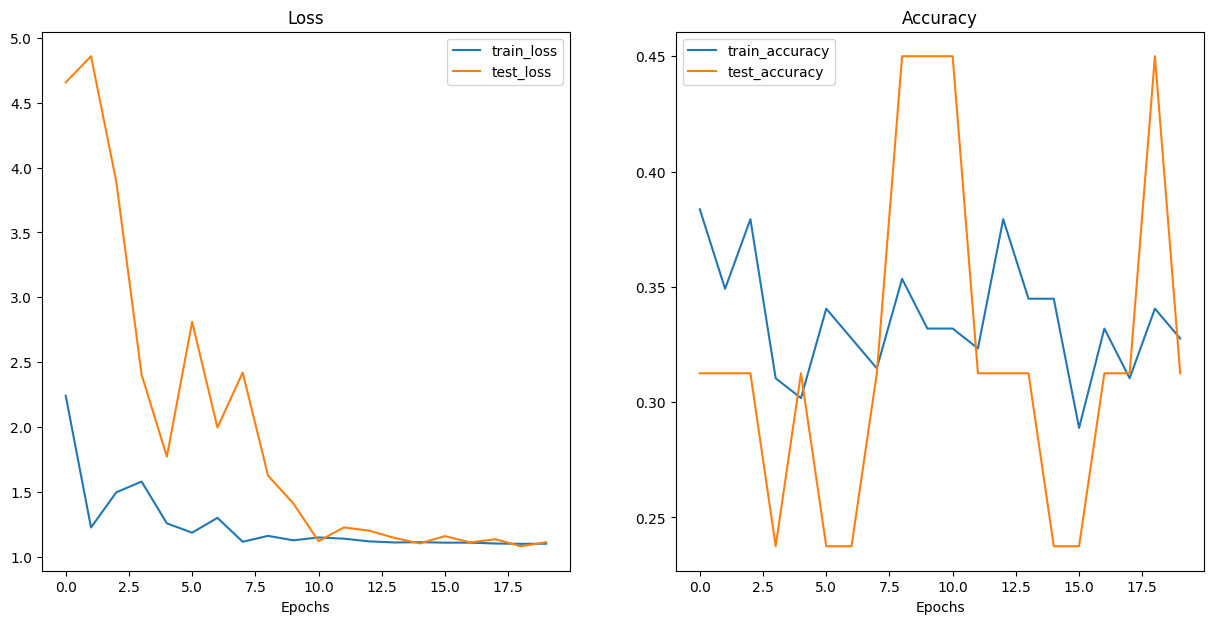

In [59]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

Sangat underfitting bukan?

## 10. Using a pretrained ViT from `torchvision.models` on the same dataset

### 10.1 Why use a pretrained model?

Alasan kenapa banyak modern machine learning papers menghasilkan hasil yang lebih baik adalah karena mereka menggunakan dataset yang besar dan sumber daya komputasi yang besar.

Selain itu waktu yang dibutuhkan untuk melakukan training juga sangat lama. Untuk ViT-L/16 sendiri ditraining pada TPUv3 dengan 8 cores selama **30 hari** yang menghabiskan kurang lebih **$5,760 USD**/

Maka dari itu, dari pada kita melakukan training dari awal, kita dapat menggunakan model yang sudah ditraining oleh orang lain. Hal ini disebut dengan **transfer learning**.

### 10.2 Getting a pretrained ViT model and creating a feature extractor

In [60]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [61]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 134MB/s] 


In [62]:
# # Print a summary using torchinfo (uncomment for actual output)
# summary(model=pretrained_vit,
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 10.3 Preparing data for the pretrained ViT model

In [63]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [64]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [65]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [66]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### 10.4 Train feature extractor ViT model

In [68]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769

Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977

Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186

Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186

Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977

Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280

Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883

Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081

Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384

Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


Hasilnya mantap!

### 10.5 Plot feature extractor ViT model loss curves

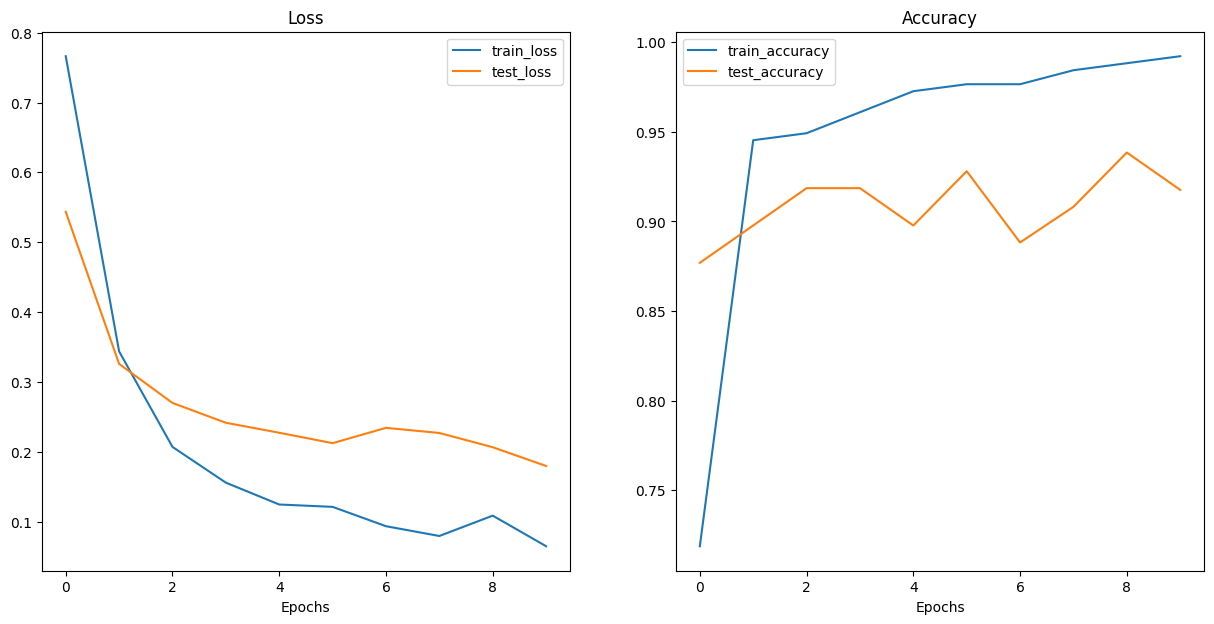

In [69]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

Hasil dari transfer learning memang menakjubkan!

### 10.6 Save feature extractor ViT model and check file size

In [71]:
# Save the model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


Ini besar banget kalau disave, kurang lebih 327 MB. Hanya untuk bobotnya saja. Jika dibanding dengan arsitektur lain, banyak yang lebih rendah.